# Status based classification

In [9]:
import pandas as pd
import numpy as np

objects_raw = pd.read_csv("../data/objects.csv", sep=",", low_memory=False)
objects = objects_raw.copy(deep=True)

objects.status.value_counts()

operating      443663
acquired         9394
live             4349
closed           2773
ipo              1134
beta              780
development       226
private           219
alpha             113
Name: status, dtype: int64

Let's define some helper functions.

In [2]:
from sklearn.base import TransformerMixin


class RowIterator(TransformerMixin):
    """
    Prepare dataframe for DictVectorizer
    """

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return (row for _, row in X.iterrows())


class FillingNans(object):
    """
    Custom function for assembling into the pipeline object
    """

    def transform(self, X):
        nans_replaced = X.fillna(0)
        return nans_replaced

    def fit(self, X, y=None):
        return self

In [3]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# exclude companies with operating status
# this status is pretty useless, because it doesn't tell much about how successful this company is
# operating status just tells us that company is still existing, which is a pretty neutral fact
objects = objects[objects["status"] != 'operating']

# build text features with dictionary vectorizer method
vectX = make_pipeline(FillingNans(), RowIterator(), DictVectorizer())
dict_vect_features = vectX.fit_transform(objects.filter(['entity_type', 'category_code', 'country_code', 'state_code']))

# build text features with TfId vectorizer method
objects_text = objects.filter(['description', 'short_description'])
texts = [' '.join(map(lambda x: '' if str(x) == 'nan' else x, value)).strip() for value in objects_text.values]
tdif_vect = TfidfVectorizer()
tfid_vect_features = tdif_vect.fit_transform(texts)
pd.DataFrame(tfid_vect_features.toarray(), columns=tdif_vect.get_feature_names())

# combine separate feature matrices into a single matrix
X = hstack((dict_vect_features, tfid_vect_features))

# build expected vector
y = LabelEncoder().fit_transform(objects.filter(['status']))

# now lets split the
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# split the data into testing and training sets
X1, X2, y1, y2 = train_test_split(X, y, random_state=0, train_size=0.7)

/Users/bartolomejkozorog/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [4]:
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC


def evaluate_data(train=X1, test=X2):
    evaluate_model(DummyClassifier(strategy='most_frequent'), train, test, "Dummy")
    evaluate_model(SVC(kernel='linear'), train, test, "SVM")


def evaluate_model(model, train, test, label):
    model.fit(train, y1)
    y2_model = model.predict(test)
    print(f"{label}: ", accuracy_score(y2, y2_model))

## Model evaluation

Let's first evaluate the data without any transormations.

In [5]:
evaluate_data()

Dummy:  0.4860452869931543
SVM:  0.7303844128488678


Now let's use SVD method for dimensionality reduction.

In [6]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=50)
proj_X1 = svd.fit_transform(X1)
proj_X2 = svd.fit_transform(X2)
evaluate_data(train=proj_X1, test=proj_X2)

Dummy:  0.4860452869931543
SVM:  0.7187993680884676


Plot the explained variance curve with respect to the number of components for SVD.

Text(0, 0.5, 'cumulative explained variance')

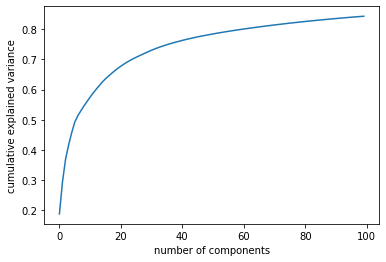

In [7]:
import matplotlib.pyplot as plt

svd = TruncatedSVD(n_components=100)
projected = svd.fit_transform(X)
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')